In [1]:
import cvxpy as cp
from scipy.sparse import csr_array
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Basis:
    def __init__(self, ops: list[str]):
        self._ops = ops
        self._mapping = {op: i for i, op in enumerate(ops)}
        self._sz = len(ops)
    
    def rank(self, word: str):
        v = self._sz ** (len(word)) - 1
        for i, op in enumerate(reversed(word)):
            v += self._mapping[op] * (self._sz ** i)
        return v

    def unrank(self, pos: int):
        len = 0
        while self._sz ** len - 1 <= pos:
            len += 1
        len -= 1
        pos -= self._sz ** len - 1
        word = [None] * len
        for i in range(len):
            word[i] = self._ops[pos % self._sz]
            pos //= self._sz
        return ''.join(word[::-1])

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # 1 2 2 1
            word = word1[:i] + word2[:j] + word2[j+1:] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

In [3]:
def canonical_relation(word1: str, word2: str):
    t1 = word1 + 'xp' + word2
    t2 = word1 + 'px' + word2
    t3 = word1 + word2
    return [(t1, 1), (t2, -1), (t3, -1j)]

def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for term in terms:
            if term[0] == '+':
                expression.append((term[1:], coeff))
            else:
                expression.append((term[1:], -coeff))
    return expression

def normalization(B):
    return [B[0] == 1]

def reality(basis: Basis, B, word: str):
    return [B[basis.rank(word[::-1])] == cp.conj(B[basis.rank(word)])]

def thermal_density_matrix(basis: Basis, B, L):
    n = 2 ** (L//2 + 1) - 1
    M = cp.bmat([[B[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))] for j in range(n)] for i in range(n)])
    return [M >> 0]

In [4]:
def beta_independent_constraints(basis, B, L, hamil):
    constraints = []
    constraints.extend(normalization(B))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = 2 ** (L + 1) - 1
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for term in terms:
            if basis.rank(term[0]) >= n:
                return
        for term in terms:
            cnt += 1
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for i in range(n):
        word = basis.unrank(i)
        add_terms(schwinger_dyson(hamil, word))
        reality(basis, B, word)
        for j in range(n):
            word2 = basis.unrank(j)
            add_terms(canonical_relation(word, word2))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def test_kms(basis, H, hamil, beta, L, k):
    d = 0
    for _, word in hamil:
        d = max(d, len(word))
    n = 2 ** ((L - d + 2) // 2 + 1) - 1
    constraints = []
    def get_A_term(i, j):
        return H[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))]
    def get_B_term(i, j):
        return H[basis.rank(basis.unrank(j) + basis.unrank(i)[::-1])]
    A = cp.bmat([[get_A_term(i, j) for j in range(n)] for i in range(n)])
    B = cp.bmat([[get_B_term(i, j) for j in range(n)] for i in range(n)])
    def get_C_term(i, j):
        # consider replacing with cp.sum
        expression = []
        for coeff, w in hamil:
            terms = commutator(w, basis.unrank(j))
            for term in terms:
                if term[0] == '+':
                    expression.append(coeff * H[basis.rank(basis.unrank(i)[::-1] + term[1:])])
                else:
                    expression.append(-coeff * H[basis.rank(basis.unrank(i)[::-1] + term[1:])])
        return 1j * cp.sum(expression)
    C = cp.bmat([[get_C_term(i, j) for j in range(n)] for i in range(n)])
    T = 2**(-k) * beta * C
    Zs = [B] + [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(1, k + 1)]
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    al, be, ga, de = -1, 5, 2, 4
    b = (be*de - ga) / (be - al)
    a = de - b
    constraints.append(cp.bmat([[Zs[k] + al*A + a*T, np.sqrt(a*b) * T],
                                [np.sqrt(a*b) * T, Zs[k] + be*A + b*T]]) >> 0)
    return constraints

In [19]:
def construct_problem(hamil, L, k):
    basis = Basis(['x','p'])
    B = cp.Variable(2**(L+1) - 1, complex=True)
    beta = cp.Parameter(nonneg = True)
    constraints = []
    constraints.extend(beta_independent_constraints(basis, B, L, hamil))
    constraints.extend(test_kms(basis, B, hamil, beta, L, k))
    energy = cp.real(sum(coeff * B[basis.rank(word)]  for coeff, word in hamil))
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    maxprob = cp.Problem(cp.Maximize(energy), constraints)
    return beta, minprob, maxprob

def solve_energy(betas, beta, minprob, maxprob, verbose=True):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, val in enumerate(betas):
        beta.value = val
        if verbose:
            print(f'Solving for T={1/val}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        E_max = maxprob.solve(accept_unknown=True)
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs

In [16]:
def convergence_plot_create_problems(Lk_pairs, hamil):
    problem_data = []
    for L, k in Lk_pairs:
        problem_data.append(construct_problem(hamil, L, k))
    return problem_data

def convergence_plot_create_data(problem_data, betas):
    mins, maxs = [], []
    for beta, minprob, maxprob in problem_data:
        minsk, maxsk = solve_energy(betas, beta, minprob, maxprob, verbose=False)
        mins.append(minsk)
        maxs.append(maxsk)
    return mins, maxs

def convergence_plot_create_plot(Lk_pairs, betas, mindata, maxdata, colors, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    for Lk, mins, maxs, color in zip(Lk_pairs, mindata, maxdata, colors):
        ax.fill_between(1/betas, mins, maxs, alpha = 0.7, color=color, label=f'(L, k) = {Lk}')
        ax.plot(1/betas, mins,c ='dimgrey',linestyle='--')
        ax.plot(1/betas, maxs,c ='dimgrey',linestyle='--')
        ax.set_xlabel('T')
        ax.set_ylabel('E')
    ax.set_axisbelow(True)
    ax.grid()
    ax.legend()
    return fig, ax

<h2>Thermal anharmonic oscillator:</h2>

In [ ]:
hamil = [(1, 'pp'), (1, 'xxxx')]
L, k = 8, 1
beta, minprob, maxprob = construct_problem(hamil, L, k)

In [ ]:
betas = 1/np.linspace(0.1,0.6,num=20)
mins, maxs = solve_energy(betas, beta, minprob, maxprob)

In [ ]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, color='blue', label=f'L = {L}',zorder=2)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(k) = ({k}) anharmonic oscillator')
plt.legend()
plt.grid(zorder=1)
plt.show()

<h3>Convergence plot:</h3>

In [13]:
Lk_pairs = [(8, 3), (8, 4), (8, 5)]
problem_data = convergence_plot_create_problems(Lk_pairs, hamil)

KeyboardInterrupt: 

In [ ]:
betas = 1 / np.linspace(0.1, 0.6, num=40)
mindata, maxdata = convergence_plot_create_data(problem_data, betas)

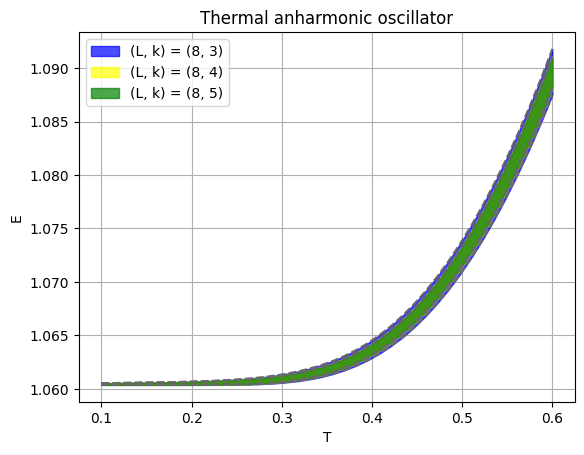

In [12]:
colors = ['blue', 'yellow', 'green']
fig, ax = convergence_plot_create_plot(Lk_pairs, betas, mindata, maxdata, colors)
plt.show()

<h2>Thermal harmonic oscillator:</h2>

In [20]:
hamil = [(1, 'pp'), (1, 'xx')]
L, k = 2, 3
beta, minprob, maxprob = construct_problem(hamil, L, k)

In [10]:
betas = 1/np.linspace(0.1,20,num=100)
mins, maxs = solve_energy(betas, beta, minprob, maxprob,verbose=False)

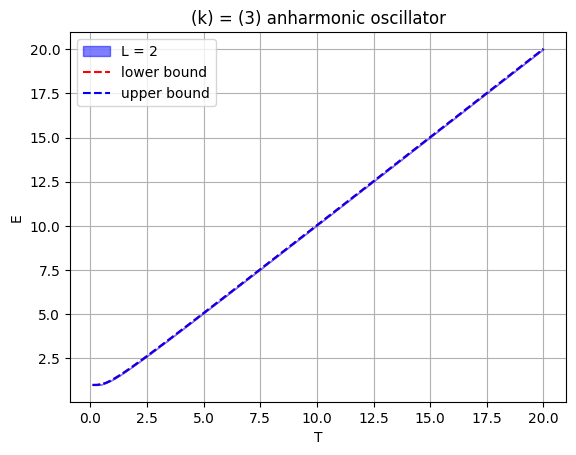

In [11]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, color='blue', label=f'L = {L}',zorder=2)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound',zorder=3)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound',zorder=3)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'(k) = ({k}) anharmonic oscillator')
plt.legend()
plt.grid(zorder=1)
plt.show()

In [21]:
Lk_pairs = [(4, 3), (6, 3)]
hamil = [(1, 'pp'), (1, 'xx')]
problem_data = convergence_plot_create_problems(Lk_pairs, hamil)

In [22]:
betas = 1 / np.linspace(0.1, 0.6, num=40)
mindata, maxdata = convergence_plot_create_data(problem_data, betas)

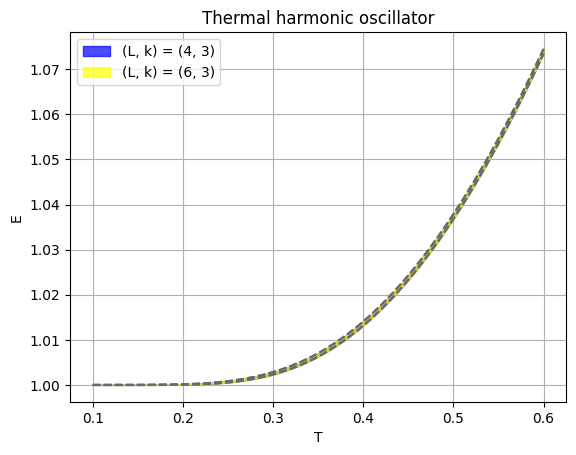

In [23]:
colors = ['blue', 'yellow', 'green']
fig, ax = convergence_plot_create_plot(Lk_pairs, betas, mindata, maxdata, colors, 'Thermal harmonic oscillator')
plt.show()